# AutoEncoder를 통해 생성한 잠재 공간을 기반으로 mnist 손글씨 숫자를 생성하는 예제
* Encoder 및 Decoder 기능은 Sequential API로 제작

In [32]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from scipy.stats import norm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# set parameters
batch_size = 100
origin_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs=50
epsilon_std = 1

In [34]:
# sampling 함수 생성
def sampling(args: tuple):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)

  return z_mean + K.exp(z_log_var / 2) * epsilon

In [35]:
# Encoder 생성 - Functional API
x = Input(shape=(origin_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)   # 잠재공간 z의 평균(정규 분포)
z_log_var = Dense(latent_dim, name='log-variance')(h)  # 잠재공간 z의 로그 분산(정규 분포)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  # 잠재공간 z

encoder = Model(x, [z_mean, z_log_var, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [36]:
# Decoder 생성 - Functional API
input_decoder = Input(shape=(latent_dim,), name='decoder_input')
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder) # 잠재공간 z를 중간층의 차원으로 재변환
x_decoded = Dense(origin_dim, activation='sigmoid', name='flat_decoded')(decoder_h)  # 원본 차원으로 이미지 재변환
decoder = Model(input_decoder, x_decoded, name='decoder') 
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# Concatenate Encoder & Decoder --> Variational AutoEncoder

output_combined = decoder(encoder(x)[2])  # 인코더에 input=x 를 넣었을때 출력값을 디코더에 삽입
                                          # 인코더의 [2]번째 출력값 --> z --> 잠재공간 z를 디코더에 삽입
vae = Model(x, output_combined)  # input과 output 연결
print(vae.summary())  

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# loss_function & model compile
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor, z_log_var=z_log_var, z_mean=z_mean,
             origin_dim=origin_dim):
  
  xent_loss = origin_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(
                        1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1
                       )
  
  vae_loss = K.mean(xent_loss + kl_loss)  # binary_crossentropy 와 쿨백-라이블러 발산을 더해 전체 손실 생성
                                          # 쿨백-라이블러 발산 : 두 분포를 그렸을 때 겹치지 않는 부분이 쿨백-라이블러 발산에 비례하는 면적이 됨
  return vae_loss


vae.compile(optimizer='rmsprop', loss=vae_loss)

In [39]:
# Load mnist Data & preprocessing

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))  # 하나의 샘플이 28*28 행렬 사이즈가 아닌 784 크기의 배열로 만들었음
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [40]:
vae.fit(X_train, X_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 50us/sample - loss: 190.6893
Epoch 2/50
60000/60000 [==============================] - 2s 39us/sample - loss: 169.8170
Epoch 3/50
60000/60000 [==============================] - 2s 38us/sample - loss: 166.4143
Epoch 4/50
60000/60000 [==============================] - 2s 38us/sample - loss: 164.3391
Epoch 5/50
60000/60000 [==============================] - 2s 38us/sample - loss: 162.9260
Epoch 6/50
60000/60000 [==============================] - 2s 38us/sample - loss: 161.7723
Epoch 7/50
60000/60000 [==============================] - 2s 38us/sample - loss: 160.6834
Epoch 8/50
60000/60000 [==============================] - 2s 38us/sample - loss: 159.6704
Epoch 9/50
60000/60000 [==============================] - 2s 38us/sample - loss: 158.7398
Epoch 10/50
60000/60000 [==============================] - 2s 38us/sample - loss: 157.8896
Epoch 11/50
60000/60000 [==============================] - 3s 45us/sample - 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


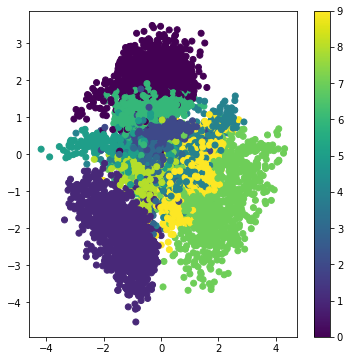

In [41]:
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:,0], X_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

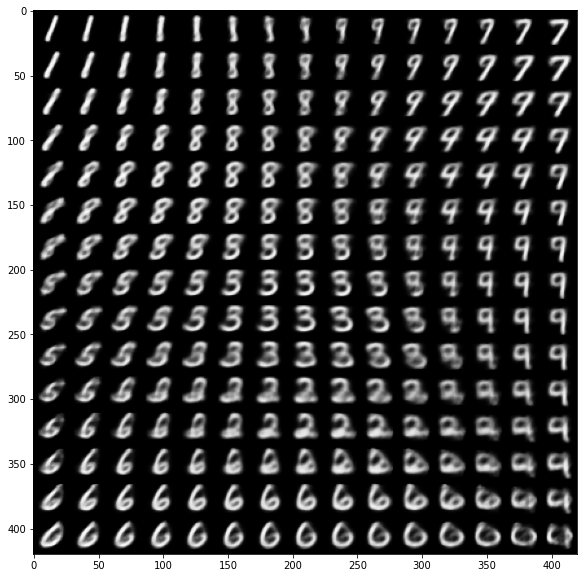

In [42]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()